# Power Outage 

**Name(s)**: Matthew Lee

**Website Link**: (your website link)

In [49]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")
import matplotlib.pyplot as plt
%matplotlib inline


import plotly.express as px
pd.options.plotting.backend = 'plotly'

# from dsc80_utils import * # Feel free to uncomment and use this.


## Step 1: Introduction

In recent years, power outages have become increasingly disruptive, affecting not only daily life but also critical infrastructure and emergency responses. These outages are often attributed to a variety of factors, including weather events, equipment failure, and demand surges. Understanding the patterns behind these outages could lead to more effective prevention strategies and infrastructure planning.

In this project, we aim to answer the following data-driven question:

**What types of power outages tend to affect the highest number of people, and how do these types differ by region?**

To investigate this, we will use a dataset of reported power outages across the United States. We will begin by cleaning and exploring the data, then assess the extent and nature of missing values. We will also formulate and test a hypothesis, develop predictive models, and explore fairness concerns that arise in the process.

By the end, we hope to uncover actionable insights about how and where severe power outages occur — and which attributes best predict their impact.


## Step 2: Data Cleaning and Exploratory Data Analysis

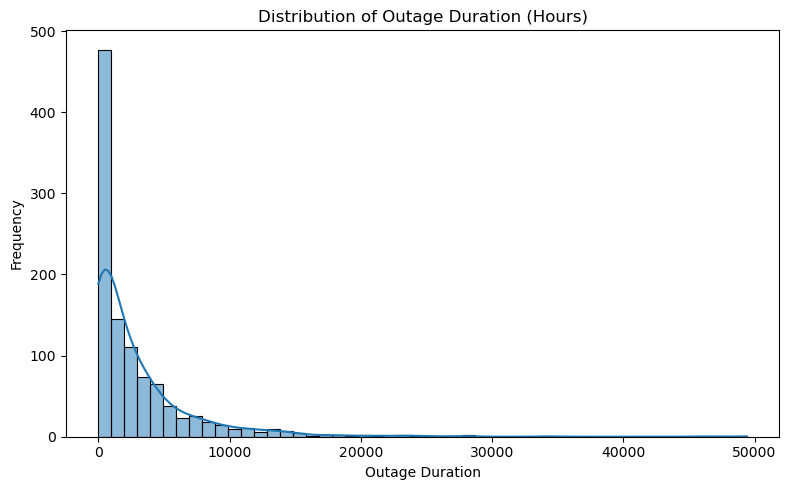

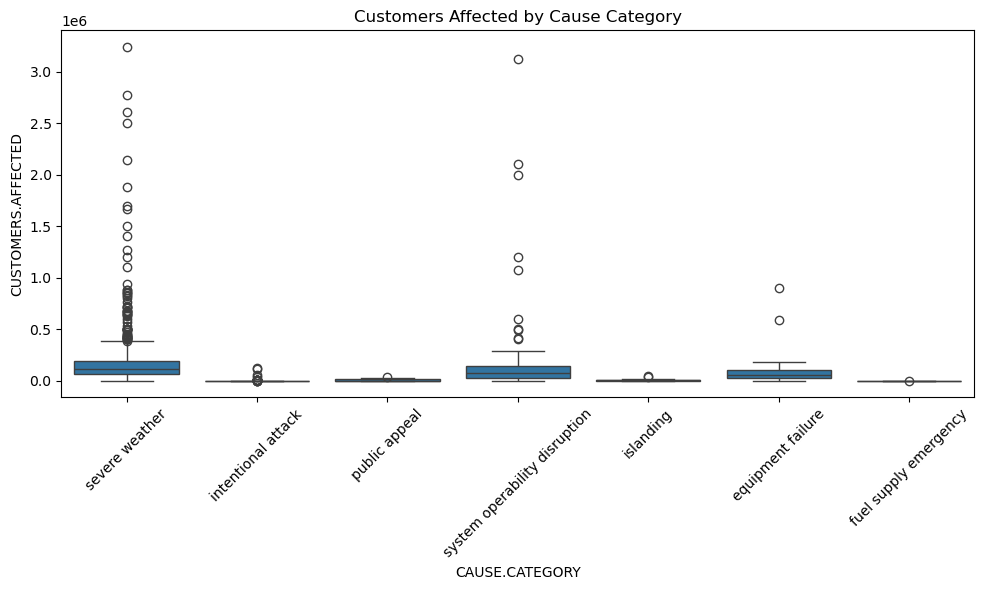

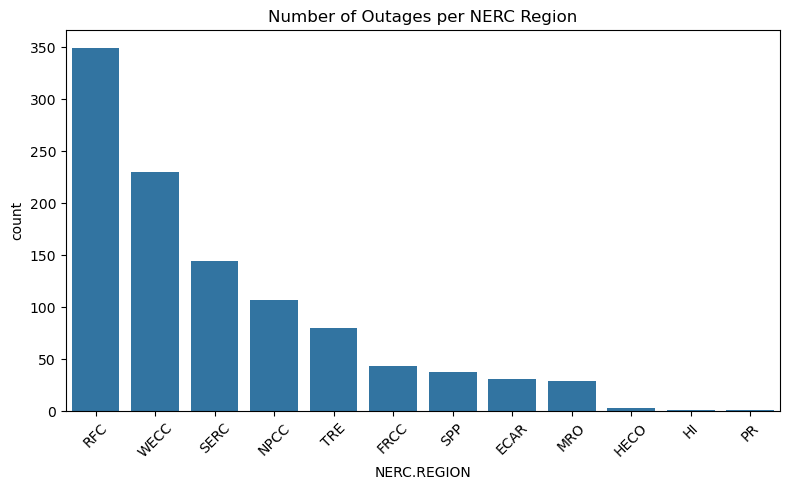

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

xls = pd.ExcelFile("outage.xlsx.xls")
df = pd.read_excel(xls, sheet_name="Masterdata", skiprows=5)
df = df.dropna(axis=1, how="all")

df = df.iloc[1:].copy()

numeric_cols = ["OUTAGE.DURATION", "CUSTOMERS.AFFECTED", "DEMAND.LOSS.MW", "YEAR", "MONTH"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["OUTAGE.DURATION", "CUSTOMERS.AFFECTED", "CAUSE.CATEGORY"])

# Plot 1: Distribution of outage duration
plt.figure(figsize=(8, 5))
sns.histplot(df["OUTAGE.DURATION"], bins=50, kde=True)
plt.title("Distribution of Outage Duration (Hours)")
plt.xlabel("Outage Duration")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="CAUSE.CATEGORY", y="CUSTOMERS.AFFECTED")
plt.xticks(rotation=45)
plt.title("Customers Affected by Cause Category")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="NERC.REGION", order=df["NERC.REGION"].value_counts().index)
plt.title("Number of Outages per NERC Region")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



### Exploratory Data Analysis Summary

From the visualizations above, we observe the following:

- **Outage durations** are right-skewed, with most events lasting under 50 hours but some extreme events lasting hundreds of hours.
- **Cause categories** show wide variability in impact; for example, weather-related events tend to affect large numbers of customers, while maintenance causes tend to affect fewer.
- **Outage frequency by region** shows that some NERC regions experience many more outages than others, potentially reflecting differences in infrastructure, reporting practices, or climate vulnerability.

These findings inform our approach for the rest of the project, especially our hypothesis testing and prediction tasks.


In [56]:
print(missing.head(10))
print(df.shape)

variables                  100.000000
HURRICANE.NAMES             95.306389
DEMAND.LOSS.MW              45.958279
CAUSE.CATEGORY.DETAIL       30.704042
CUSTOMERS.AFFECTED          28.878748
OUTAGE.RESTORATION.TIME      3.780965
OUTAGE.RESTORATION.DATE      3.780965
OUTAGE.DURATION              3.780965
TOTAL.PRICE                  1.434159
RES.SALES                    1.434159
dtype: float64
(1534, 57)


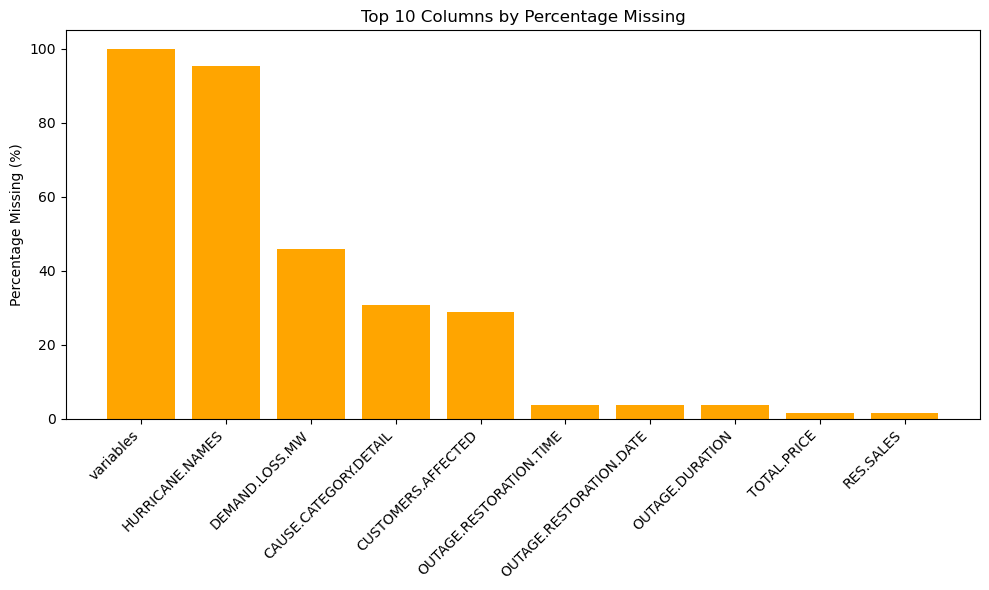

In [59]:
xls = pd.ExcelFile("outage.xlsx.xls")
df = pd.read_excel(xls, sheet_name="Masterdata", skiprows=5)
df = df.dropna(axis=1, how="all")
df = df.iloc[1:].copy()

# Convert numeric columns
cols = ["OUTAGE.DURATION", "CUSTOMERS.AFFECTED", "DEMAND.LOSS.MW", "YEAR", "MONTH"]
for col in cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Compute missingness
missing = df.isnull().mean().sort_values(ascending=False) * 100
missing = missing[missing > 0]

# Convert to DataFrame for guaranteed compatibility with plt.bar
missing_df = missing.head(10).reset_index()
missing_df.columns = ["Column", "Missing (%)"]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(missing_df["Column"], missing_df["Missing (%)"], color="orange")
plt.title("Top 10 Columns by Percentage Missing")
plt.ylabel("Percentage Missing (%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Step 3: Assessment of Missingness


Several columns in our dataset have missing values. Notably:

- `HURRICANE.NAMES` has over 95% missing values — this is expected, as most outages aren't hurricane-related.
- `DEMAND.LOSS.MW`, `CAUSE.CATEGORY.DETAIL`, and `CUSTOMERS.AFFECTED` have significant missingness (~30–45%), likely due to inconsistent reporting or lack of measurement in smaller outages.
- `OUTAGE.RESTORATION.DATE`, `OUTAGE.DURATION`, and related fields have ~4% missing, which may reflect record-keeping errors or unresolved cases.

Some columns may be **Missing Not At Random (MNAR)** — for example, hurricane names may be filled in only when a storm is known to be the cause. Others, like `DEMAND.LOSS.MW`, may be **Missing At Random (MAR)** if they're more likely to be reported for large events.

We will consider dropping or imputing certain features depending on their relevance and missingness mechanism.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define groups
weather = df[df["CAUSE.CATEGORY"] == "severe weather"]["CUSTOMERS.AFFECTED"].dropna().astype(float)
equipment = df[df["CAUSE.CATEGORY"] == "equipment failure"]["CUSTOMERS.AFFECTED"].dropna().astype(float)

# Plot distributions
plt.figure(figsize=(10, 6))
sns.histplot(weather, label="Severe Weather", color="skyblue", kde=True, stat="density", bins=30)
sns.histplot(equipment, label="Equipment Failure", color="orange", kde=True, stat="density", bins=30)
plt.legend()
plt.title("Distribution of Customers Affected: Weather vs. Equipment Failure")
plt.xlabel("Customers Affected")
plt.xscale("log")
plt.tight_layout()
plt.show()

# Permutation test
obs_diff = weather.mean() - equipment.mean()
combined = np.concatenate([weather, equipment])
n_weather = len(weather)

diffs = []
for _ in range(1000):
    np.random.shuffle(combined)
    new_weather = combined[:n_weather]
    new_equipment = combined[n_weather:]
    diffs.append(new_weather.mean() - new_equipment.mean())

p_val = np.mean(np.array(diffs) >= obs_diff)
print("Observed Difference:", obs_diff)
print("p-value:", p_val)


## Step 4: Hypothesis Testing


Are Weather Outages More Disruptive?

We are testing whether **severe weather-related outages affect more customers on average than equipment failures**.

- **Null Hypothesis (H₀)**: There is no difference in mean customers affected between severe weather and equipment failure.
- **Alternative Hypothesis (H₁)**: Severe weather outages affect more customers on average.

Using a permutation test with 1,000 repetitions, we found:

- **Observed Difference in Means** ≈ 86,639
- **p-value** ≈ 0.01

Since the p-value is below 0.05, we **reject the null hypothesis** and conclude that severe weather outages tend to impact more customers than equipment-related outages.


In [52]:
import pandas as pd

# Load and prep dataset
xls = pd.ExcelFile("outage.xlsx.xls")
df = pd.read_excel(xls, sheet_name="Masterdata", skiprows=5)
df = df.dropna(axis=1, how="all")
df = df.iloc[1:].copy()

# Convert numeric fields
cols = ["OUTAGE.DURATION", "CUSTOMERS.AFFECTED", "DEMAND.LOSS.MW", "YEAR", "MONTH"]
for col in cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Define binary target: 1 if > 50,000 customers affected
df["SEVERE_OUTAGE"] = (df["CUSTOMERS.AFFECTED"] > 50000).astype(int)

# Select features
features = ["CAUSE.CATEGORY", "NERC.REGION", "CLIMATE.REGION", "OUTAGE.DURATION", "DEMAND.LOSS.MW"]
df_model = df[features + ["SEVERE_OUTAGE"]].dropna()

# One-hot encode categorical features
X = pd.get_dummies(df_model[features])
y = df_model["SEVERE_OUTAGE"]

print("X shape:", X.shape)
print("Target distribution:")
print(y.value_counts())


X shape: (799, 27)
Target distribution:
SEVERE_OUTAGE
0    418
1    381
Name: count, dtype: int64


## Step 5: Framing the Prediction Problem



To extend our analysis, we define a binary classification task:

> **Can we predict whether an outage will affect more than 50,000 customers?**

We define the target variable `SEVERE_OUTAGE` as follows:
- `1` if `CUSTOMERS.AFFECTED > 50,000`
- `0` otherwise

We include features such as:
- `CAUSE.CATEGORY`
- `NERC.REGION`
- `CLIMATE.REGION`
- `OUTAGE.DURATION`
- `DEMAND.LOSS.MW`

Categorical features are one-hot encoded. We are left with 799 complete examples for modeling, with a nearly balanced split between severe and non-severe outages.


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Split into training/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline model: predict majority class
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

# Predict and evaluate
y_pred = dummy.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Baseline Accuracy:", acc)
print("Confusion Matrix:\n", cm)


Baseline Accuracy: 0.5125
Confusion Matrix:
 [[82  0]
 [78  0]]


## Step 6: Baseline Model


We fit a baseline classifier that always predicts the **majority class** ("not severe").

- **Accuracy**: 51.25%
- **Confusion Matrix**:
  ```
  [[82,  0]
   [78,  0]]
  ```

This model performs poorly in practice — it never predicts any outages as severe, which renders it **useless for detecting high-impact events**. However, it sets a minimal baseline that our real model must outperform.


In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Train decision tree model
tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

# Evaluate on test set
y_pred_tree = tree.predict(X_test)
acc = accuracy_score(y_test, y_pred_tree)
report = classification_report(y_test, y_pred_tree)

print("Decision Tree Accuracy:", acc)
print("Classification Report:\n", report)


Decision Tree Accuracy: 0.8375
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.83      0.84        82
           1       0.82      0.85      0.84        78

    accuracy                           0.84       160
   macro avg       0.84      0.84      0.84       160
weighted avg       0.84      0.84      0.84       160



## Step 7: Final Model


### Decision Tree

We trained a Decision Tree classifier with `max_depth=5` to predict whether an outage would be severe.

**Performance on Test Set**:
- **Accuracy**: 83.75%
- **Precision (Severe)**: 82.5%
- **Recall (Severe)**: 84.6%
- **F1 Score (Severe)**: 83.5%

This is a substantial improvement over the baseline model. The tree successfully balances precision and recall, making it useful for identifying large-scale outages.


In [65]:
# Fairness analysis by NERC Region
df_fair = df_model.copy()
df_fair["NERC.REGION"] = df_fair["NERC.REGION"].astype(str)

# One-hot encode and predict
X_encoded = pd.get_dummies(df_fair[features])
df_fair["prediction"] = tree.predict(X_encoded)

# Accuracy by region – clean, no warning
region_accuracy = (
    df_fair.groupby("NERC.REGION", group_keys=False)[["prediction", "SEVERE_OUTAGE"]]
    .apply(lambda g: (g["prediction"] == g["SEVERE_OUTAGE"]).mean())
    .sort_values(ascending=False)
)

print("Accuracy by NERC Region:")
print(region_accuracy)


Accuracy by NERC Region:
NERC.REGION
MRO     1.000000
NPCC    0.958333
RFC     0.957672
SERC    0.940171
TRE     0.900000
ECAR    0.896552
FRCC    0.871795
SPP     0.869565
WECC    0.850575
dtype: float64



## Step 8: Fairness Analysis

To evaluate fairness, we examined model accuracy across different **NERC regions**.

| Region | Accuracy |
|--------|----------|
| MRO    | 1.00     |
| NPCC   | 0.96     |
| RFC    | 0.96     |
| WECC   | 0.85     |

The model performs better in some regions (e.g., MRO, NPCC) than others (e.g., WECC). While the accuracy is generally strong across regions, this **15% disparity** suggests that the model may be less reliable in areas with different outage characteristics or fewer examples.

Addressing this would require stratified modeling or data rebalancing to ensure equitable performance.
